# Data Scientist Challenge - A3Data
Solved by Jéssica Ferreira Soares

**Index**
- [1) Import libraries](#libraries)
- [2) Read dataset](#read-dataset)
- [3) Exploratory data analysis](#EDA)
- [4) Classification model](#model)
- [5) Feature importance](#feature-importance)

## 1) Import libraries <a class="anchor" id="libraries"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from datetime import datetime
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [2]:
pd.set_option('display.max_columns', None)

## 2) Read dataset <a class="anchor" id="read-dataset"></a>

In [3]:
df = pd.read_csv("dataset/Customer-Churn - Customer-Churn.csv")

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),"118,75","8672,45",No
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,"118,65","8477,6",No
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,"118,6","7990,05",No
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,"118,6","7365,7",No
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),"118,35","7804,15",Yes


In [5]:
def calculate_missing_values(df):
    '''Receive a dataframe and calculate the percentage of missing values'''

    # Step 1: Calculate the total number of missing values per column
    missing_values = df.isnull().sum()

    # Step 2: Calculate the total number of rows in the DataFrame
    total_rows = df.shape[0]

    # Step 3: Calculate the percentage of missing values per column
    percentage_missing = (missing_values / total_rows) * 100

    # Step 4: Create a new DataFrame to display the results
    result_df = pd.DataFrame({
        'Column': missing_values.index,
        'Percentage Missing': percentage_missing
    })

    # Step 5: Print the result DataFrame
    print(result_df)

#_______________________________________________________________________________________

def plot_bar_categorical_features(df,column_name):
    '''Plot bar plot of categorical feature using percetange in the Y axis
    given the dataframe df and the column_name'''

    available_status = df[column_name].value_counts()
    plt.figure(figsize=(10,6))
    (available_status/df.shape[0]).plot(kind="bar");
    plt.title("Perc distribution - "+column_name);
    plt.show()


## 3) Exploratory data analysis <a class="anchor" id="eda"></a>

In [6]:
#Evaluate percentage of missing values
print("df.shape = ", df.shape)
calculate_missing_values(df)

df.shape =  (7043, 21)
                            Column  Percentage Missing
customerID              customerID            0.000000
gender                      gender            0.000000
SeniorCitizen        SeniorCitizen            0.000000
Partner                    Partner            0.000000
Dependents              Dependents            0.000000
tenure                      tenure            0.000000
PhoneService          PhoneService            0.000000
MultipleLines        MultipleLines            0.000000
InternetService    InternetService            0.000000
OnlineSecurity      OnlineSecurity            0.000000
OnlineBackup          OnlineBackup            0.000000
DeviceProtection  DeviceProtection            0.000000
TechSupport            TechSupport            0.000000
StreamingTV            StreamingTV            0.000000
StreamingMovies    StreamingMovies            0.000000
Contract                  Contract            0.000000
PaperlessBilling  PaperlessBilling        

- There is a small percentage of Nan values so I decided to drop them.

In [7]:
#Drop rows with missing values
df.dropna(inplace=True)

#Verify dataframe after dropping rows with Nan values
print("df.shape = ", df.shape)
calculate_missing_values(df)

df.shape =  (7032, 21)
                            Column  Percentage Missing
customerID              customerID                 0.0
gender                      gender                 0.0
SeniorCitizen        SeniorCitizen                 0.0
Partner                    Partner                 0.0
Dependents              Dependents                 0.0
tenure                      tenure                 0.0
PhoneService          PhoneService                 0.0
MultipleLines        MultipleLines                 0.0
InternetService    InternetService                 0.0
OnlineSecurity      OnlineSecurity                 0.0
OnlineBackup          OnlineBackup                 0.0
DeviceProtection  DeviceProtection                 0.0
TechSupport            TechSupport                 0.0
StreamingTV            StreamingTV                 0.0
StreamingMovies    StreamingMovies                 0.0
Contract                  Contract                 0.0
PaperlessBilling  PaperlessBilling        

In [8]:
df.dtypes

customerID          object
gender              object
SeniorCitizen        int64
Partner             object
Dependents          object
tenure               int64
PhoneService        object
MultipleLines       object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
Contract            object
PaperlessBilling    object
PaymentMethod       object
MonthlyCharges      object
TotalCharges        object
Churn               object
dtype: object

In [9]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),"118,75","8672,45",No
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,"118,65","8477,6",No
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,"118,6","7990,05",No
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,"118,6","7365,7",No
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),"118,35","7804,15",Yes


- There are some float data that is defined as object and it has a comma to indicate the decimal point instead on a dot. A transformation is needed to better explore these columns.

In [10]:
def fix_float_cols(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: float(x.replace(",", ".")))
fix_columns_float = ['MonthlyCharges', 'TotalCharges']
for col in fix_columns_float:
    fix_float_cols(df,col)
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

array([[<Axes: title={'center': 'SeniorCitizen'}>,
        <Axes: title={'center': 'tenure'}>],
       [<Axes: title={'center': 'MonthlyCharges'}>,
        <Axes: title={'center': 'TotalCharges'}>]], dtype=object)

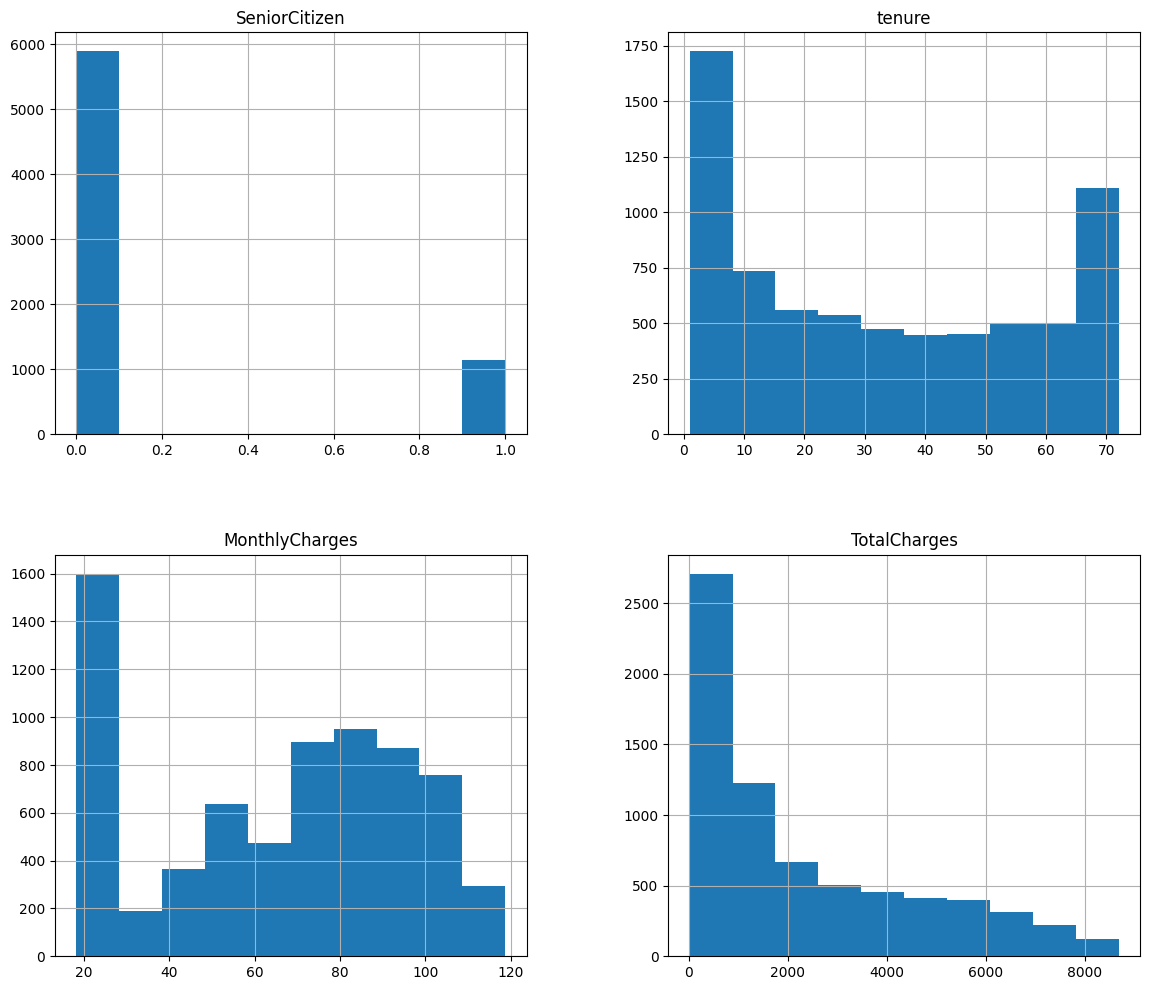

In [11]:
df.hist(figsize = (14,12))

**Insights from histogram plots**
- Because the data dictionary was not provided, the following considerations will be made about the columns:
    - tenure:number of months the customer has stayed with the company. PhoneService - whether the customer has a phone service or not (Yes, No);
    - TotalCharges: I will consider the total charges the annual charge because the values are way higher than the Monthly charges;
    - Senior citezen: an older adult and especially one who is age 65 or older.

- Observations about the numerical variables:
    - tenure:
        - Looks like most of the cusmers tend to stay less than 10 months in the telecom company;
        - The customers who passed through this initial period will tend to stay longer as a client;
    - Monthly charges:
        - Most of the clients spent less than $30 per month;
        - There is a considerable variation in the price the customers spend monthly. It might be due to the acquisition of additional services;
        - It might be interesting to check if there is a relationship between how much the customers pay according to the service they have;
    - Total charges:
        - It is interesting to observe that the distribution of the monthly charge is very different from the total charges; For now is a bit unclear why it happens.
    - Senior citizen
        - Most of the people in the database are less than 65-years-old.

In [12]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

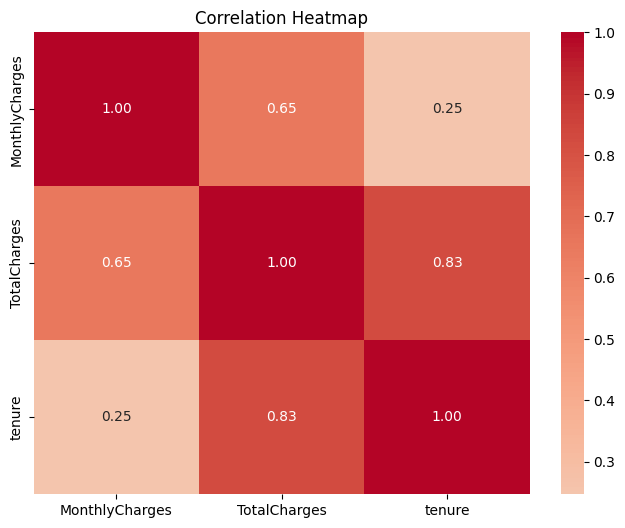

In [13]:
# Plot the correlation heatmap
data = df[['MonthlyCharges', 'TotalCharges', 'tenure']]
corr_matrix = data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


**Insights from correlation heatmap**
- There is a high correlation between the total charges and the tenure. My hypothesis is that people who spend more, use more services from the telecom company; Because they are more engaged, they tend to stay longer;
- There is a small correlation between tenure and month charges. Because the distribution of monthly charges and total charges are different, it makes sense they have a different behavior in matters of correlation with the tenure variable;
- Monthly charges and total charges have some correlation. I believe it is because the left part of distribution looks similar although the tail is different.

**Insights from barplots**
- 90% of the clients have phone service (what makes sense given that it is usually the mais service offered by a telecom company);
- 80% of the customers have hire internet service;
    - Most of the people who have internet service don't hire online security;
- Considering the customers who have internet, a little bit more than half of them do not have StreamingTV
    - Most of them do not have OnlineBackup as well and other extra services as online tv, device procection, online security, tech support
    - Most of the clients use fiber optics interneat instead of DSL.
- There are 3 types of contracts in the telecom company: monthly, 1-year, 2-year-contract;
    - Probably there is a relationship between the tenure and the type of contract;
- Around 60% of the clients use paperless billing;
- 70% of the customers do not have dependents. What are the benefits and extra costs that having a dependent might cause?
- The customer database is almost 50%/50% for male and female;
- The churn distribution is around 75% active customers and 25% churn;

**Analysis ideas**
- Check if there is a relationship between people who don't have internet service with being a senior citizen
- Check the relationship between the total charges and the serviced hired
- Check the relationship between the monthly charges and the serviced hired
- Check if there is a relationship between the tenure and the type of contract
- Seems that there are two big groups of clients: the ones who have internet and the ones who not
- It would be interesting to do a feature engineering with the PaymentMethod to create 2 cateogories instead of 4: automatic payment and manual payment; It might affect on churn or even if the bills are properly paid by the clients.
    - I just saw the payperless bill correspond be this category.
- Extra service for people who have internet: StreamingTV, online backup, device protection, online security, tech support
    - It would be an interesting idea to create a feature called extra internet services having the values of yes or no
    - Would this new variable influence in churn?
    - Would a specific extra service influence in churn?
- What being a partner means? Does it influence in how much money people pay monthly and in total?


PhoneService


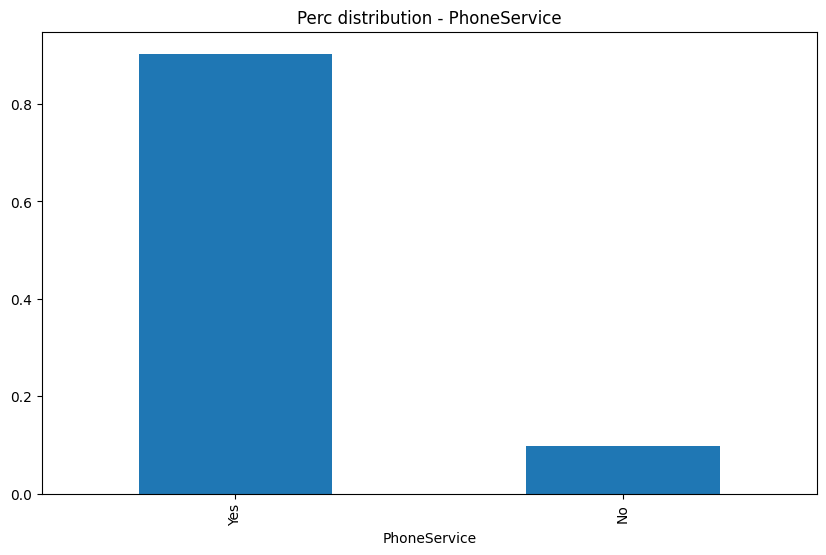

DeviceProtection


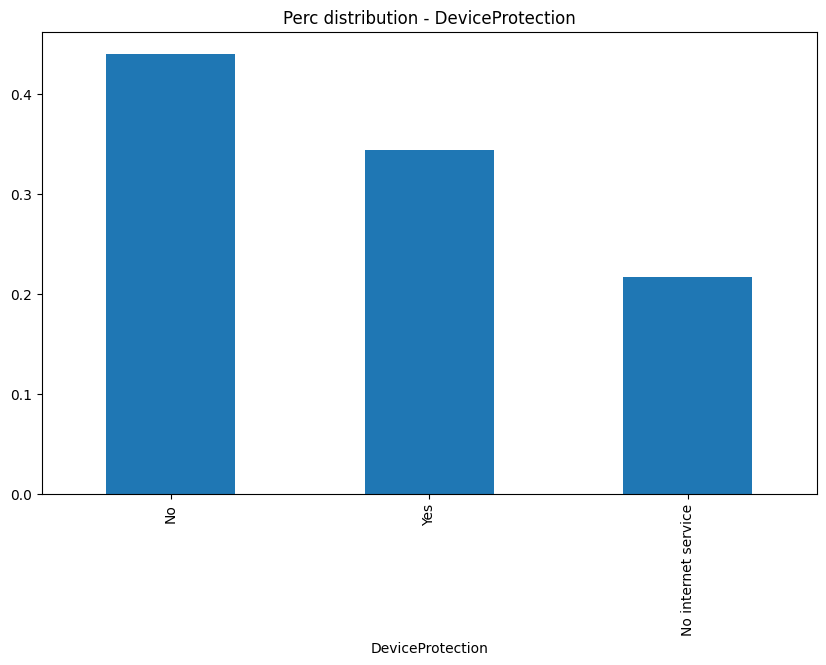

StreamingTV


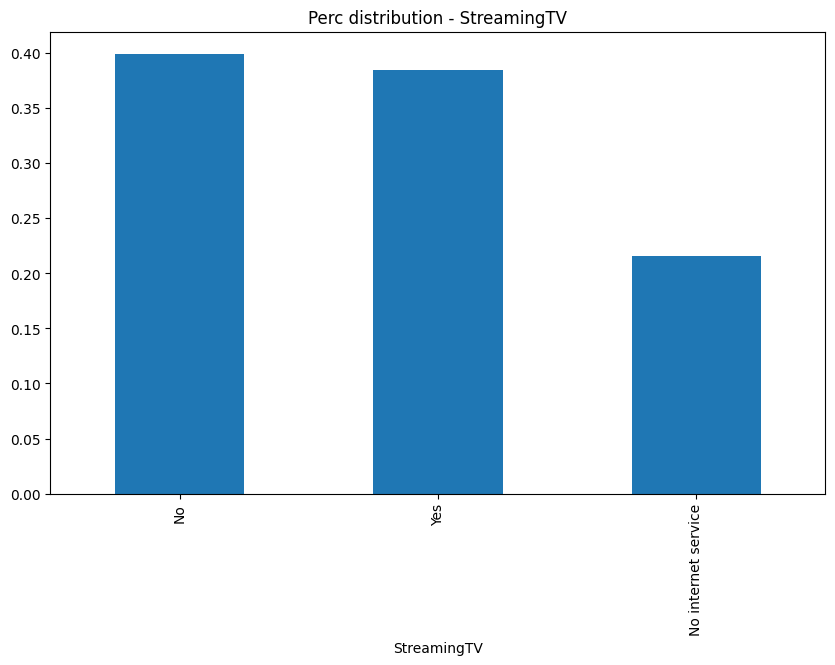

MultipleLines


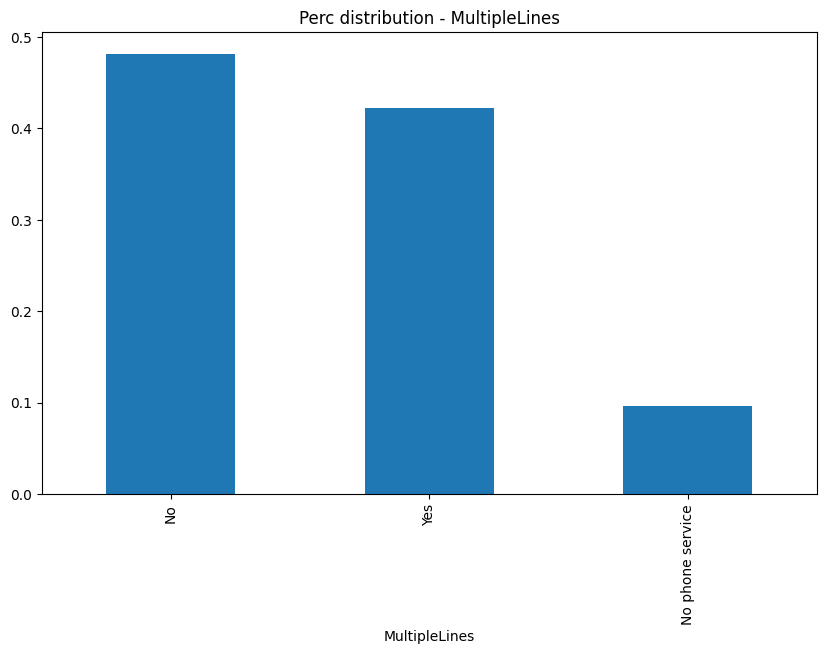

StreamingMovies


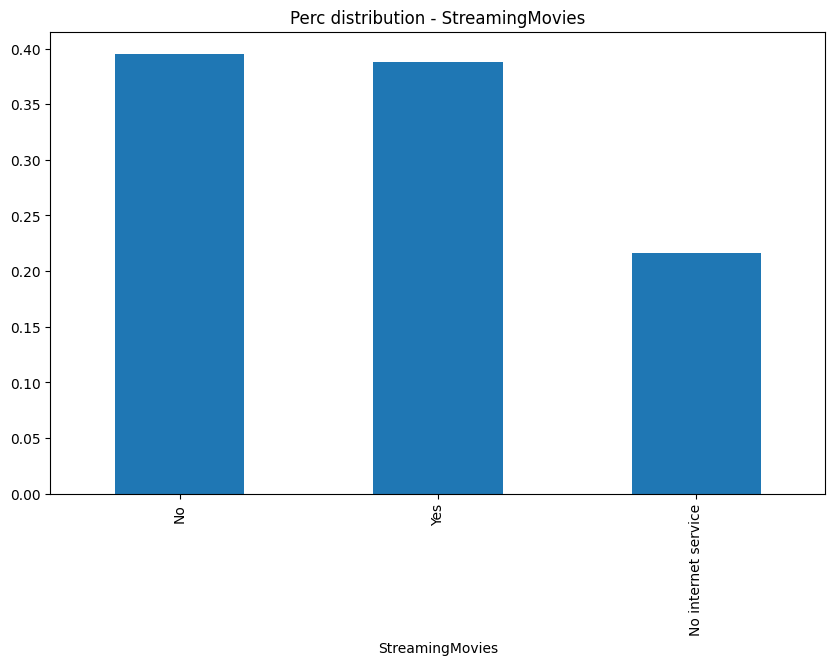

Dependents


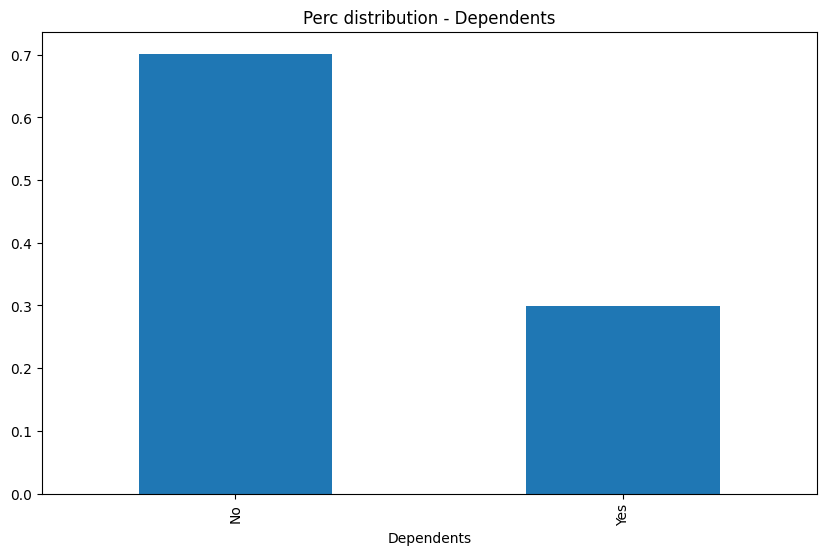

OnlineSecurity


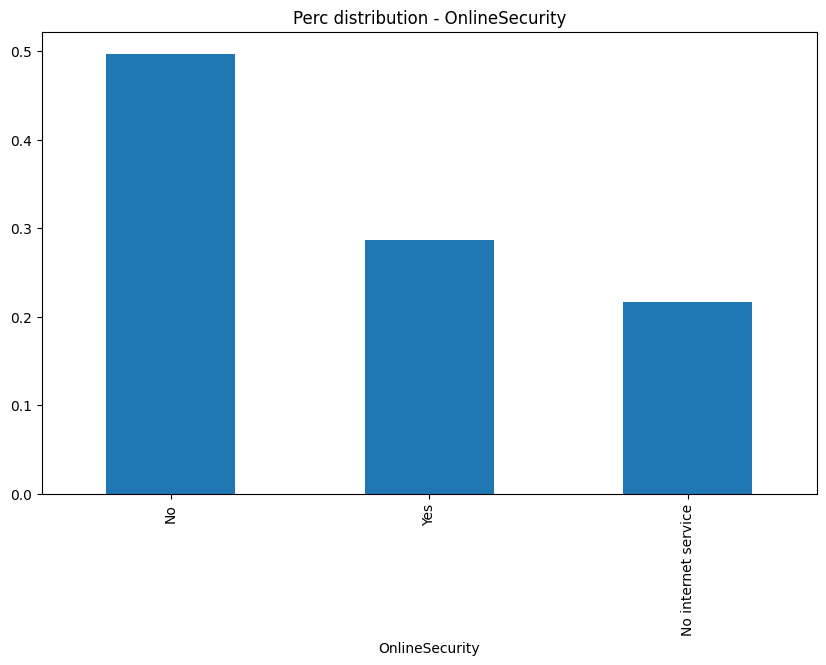

InternetService


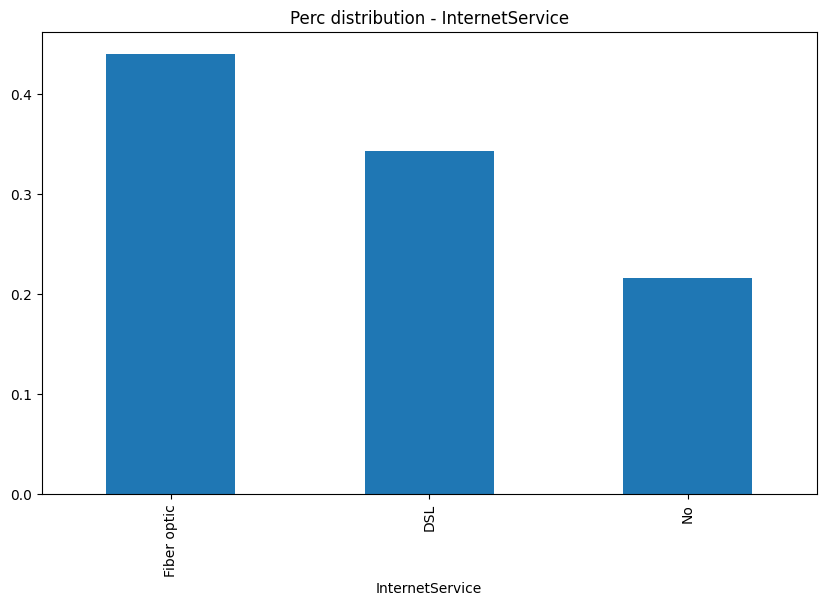

gender


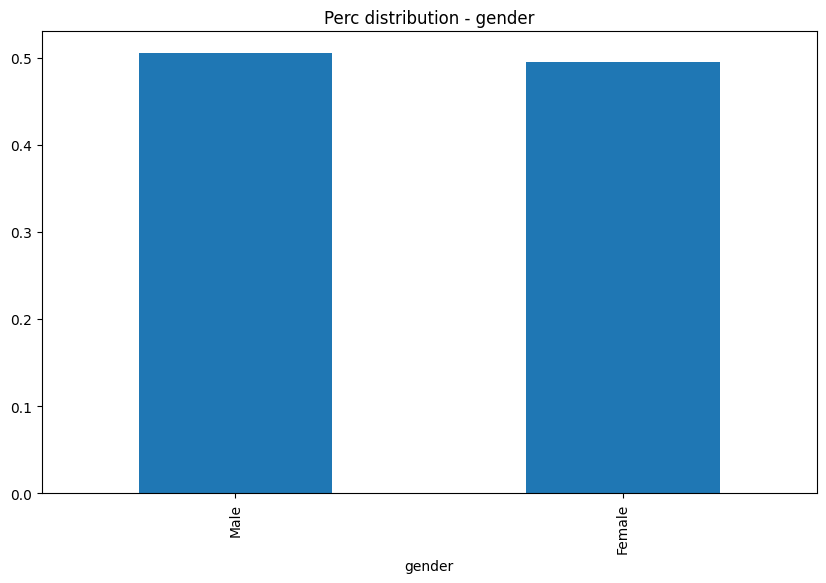

PaymentMethod


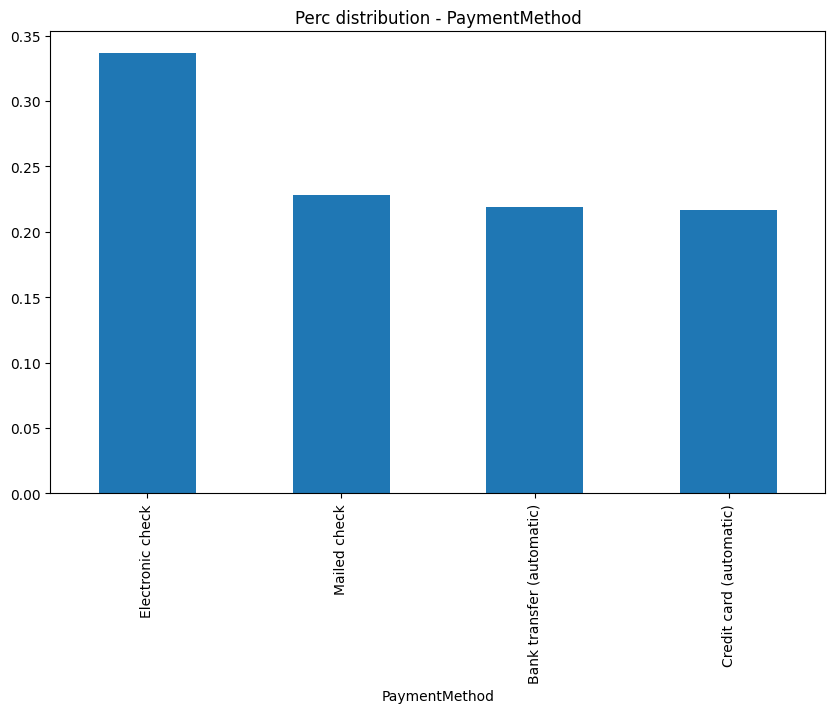

PaperlessBilling


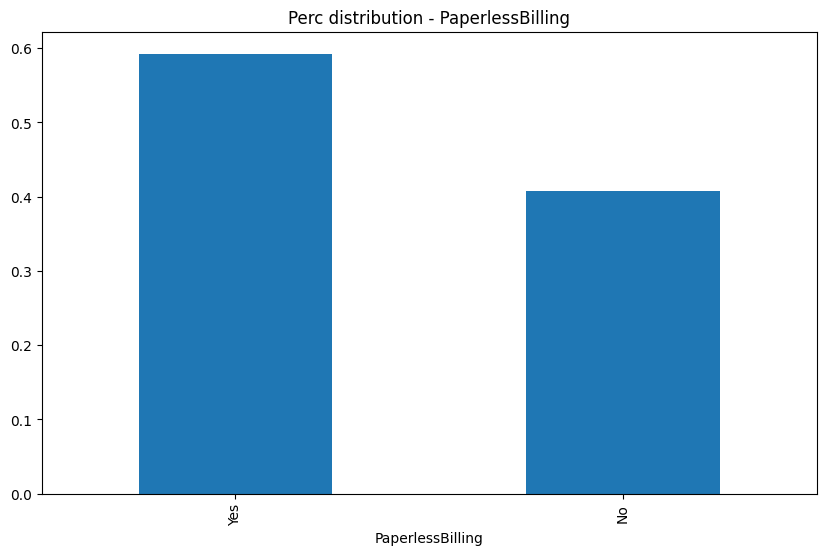

Partner


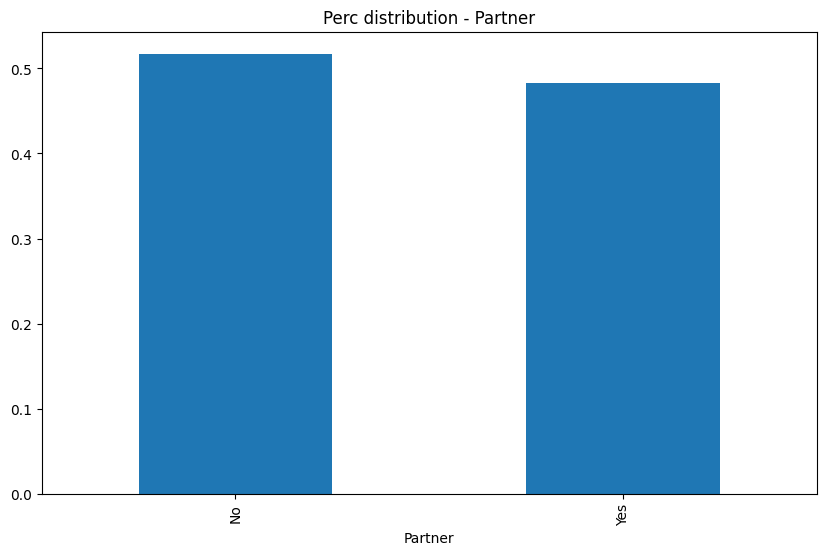

TechSupport


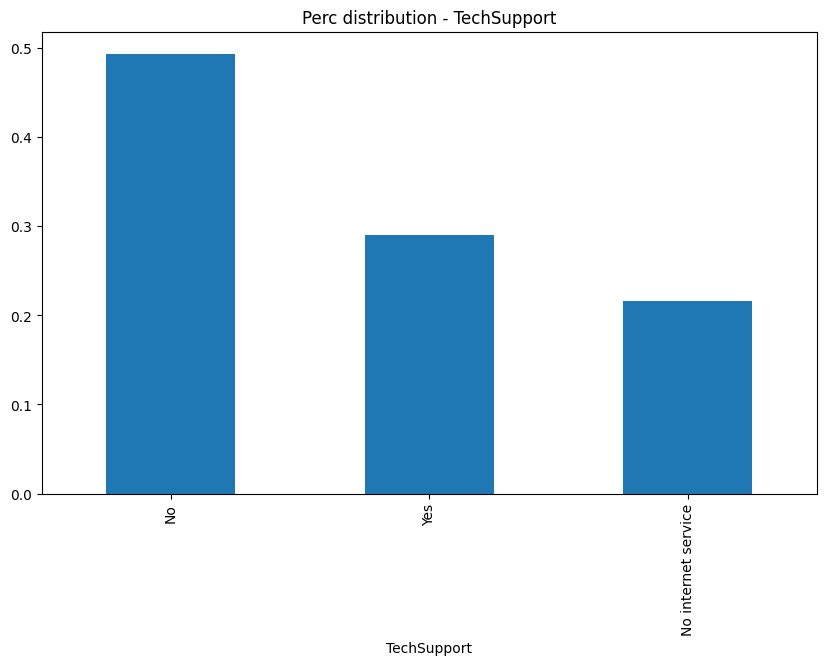

Contract


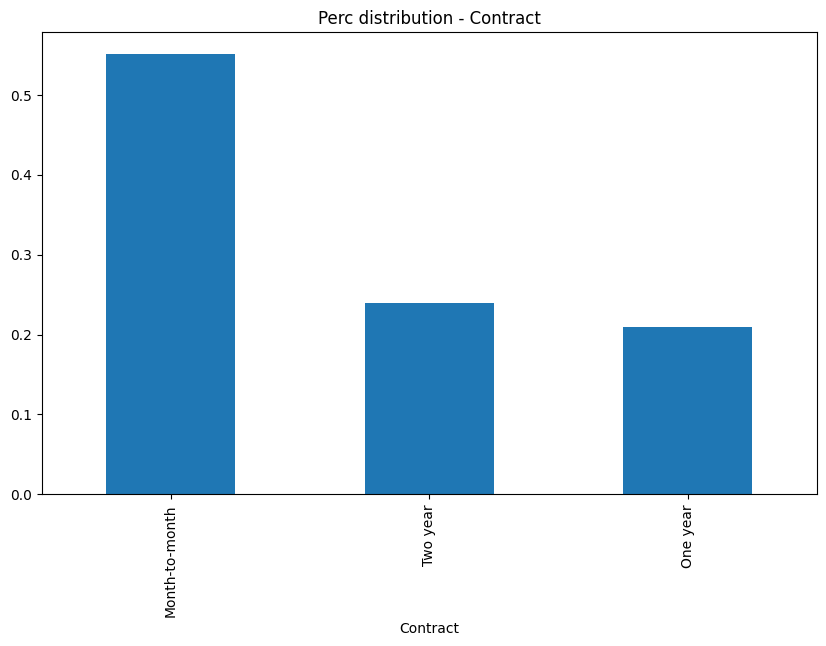

OnlineBackup


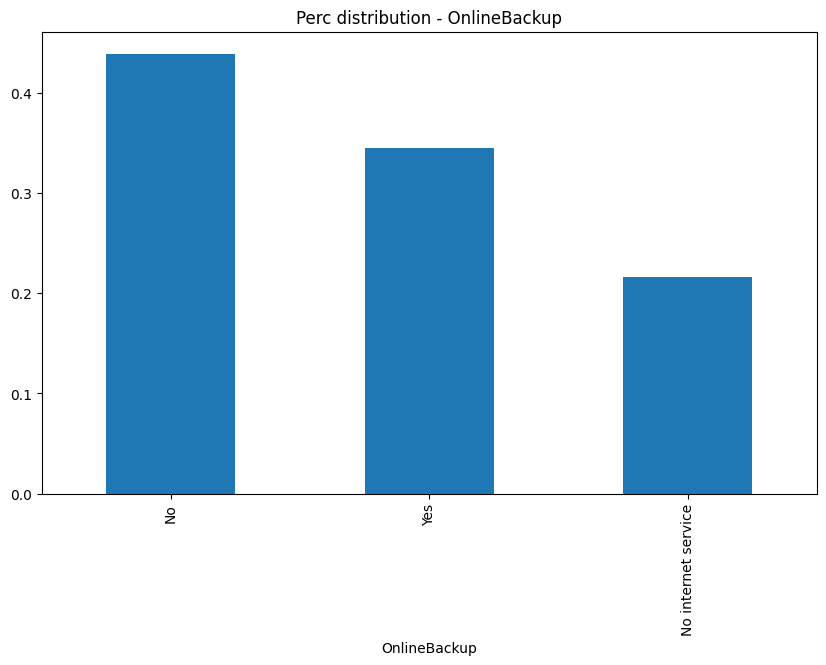

SeniorCitizen


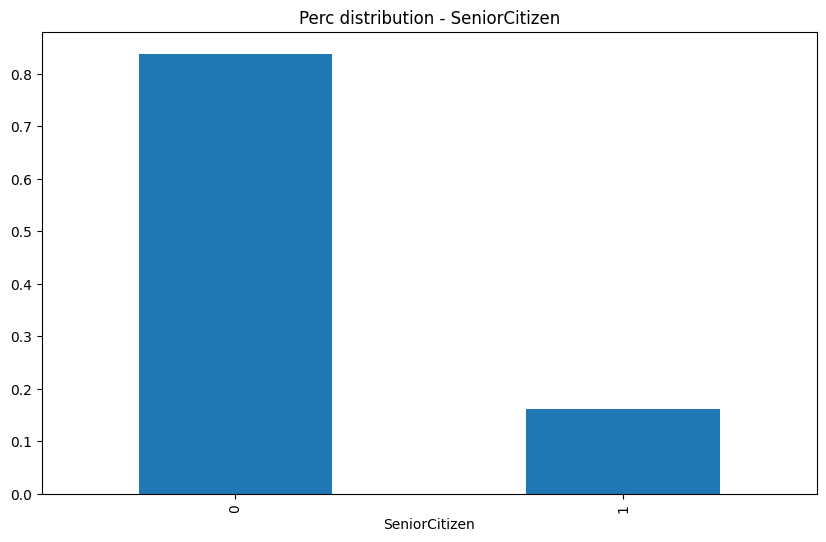

Churn


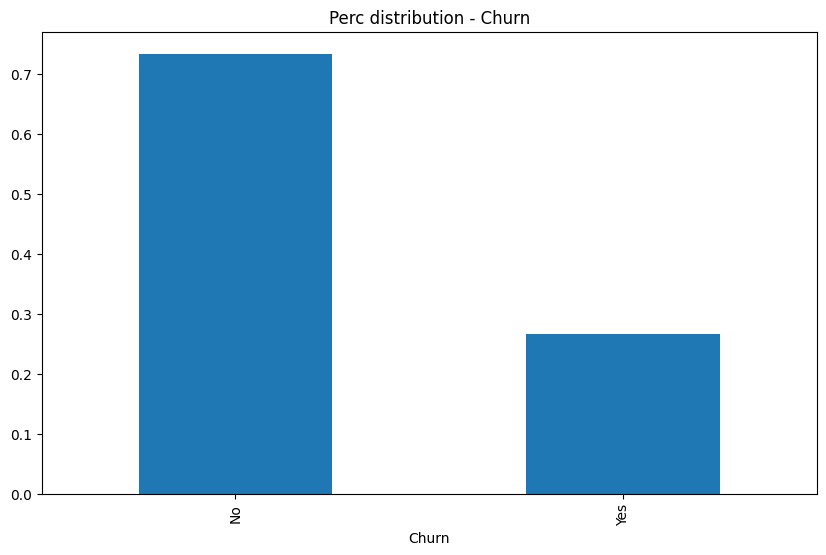

In [14]:
#Plot categorical features
additional_features = ['SeniorCitizen']
remove_features = ['customerID']
categorical_features = list(df.select_dtypes(include=["object"]).columns)
categorical_features = categorical_features + additional_features
categorical_features = list(set(categorical_features) - set(remove_features))

for col in categorical_features:
    print(col)
    plot_bar_categorical_features(df, col)

In [15]:
def plot_stacked_barplot(x, y, df, labels_description, title_description):

    grouped_data = df.groupby(y)[x].value_counts(normalize=True).unstack().fillna(0)
    grouped_data['Total Proportion'] = grouped_data.iloc[:, 1]  # Use .iloc indexer for integer index
    grouped_data = grouped_data.sort_values('Total Proportion', ascending=False).drop('Total Proportion', axis=1)

    # Plot the grouped bar plot with normalized values
    grouped_data.plot(kind='bar', stacked=True)
    plt.xlabel(y)
    plt.ylabel('Percentage of '+x)
    plt.title('Percentage of '+title_description+' per '+y)
    plt.legend(title='x', labels=labels_description, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.gca().yaxis.set_major_formatter('{:.0%}'.format)  # Format y-axis as percentage
    plt.show()

In [16]:
df['Churn'].value_counts()

Churn
No     5163
Yes    1869
Name: count, dtype: int64

In [17]:
categorical_features

['PhoneService',
 'DeviceProtection',
 'StreamingTV',
 'MultipleLines',
 'StreamingMovies',
 'Dependents',
 'OnlineSecurity',
 'InternetService',
 'gender',
 'PaymentMethod',
 'PaperlessBilling',
 'Partner',
 'TechSupport',
 'Contract',
 'OnlineBackup',
 'SeniorCitizen',
 'Churn']

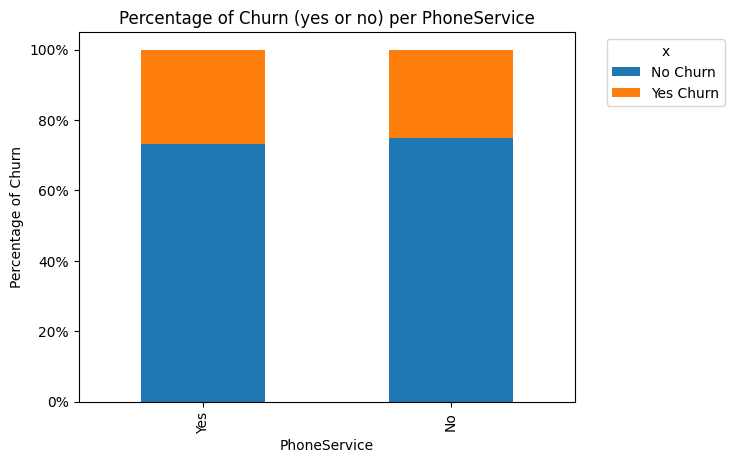

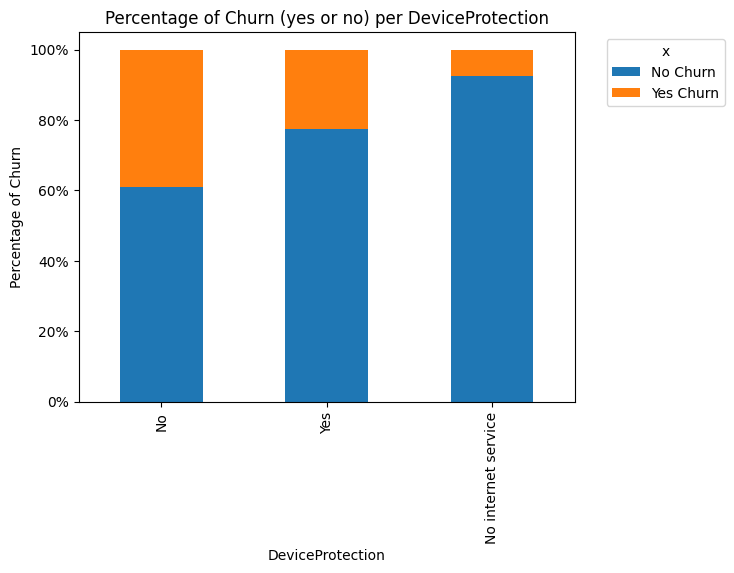

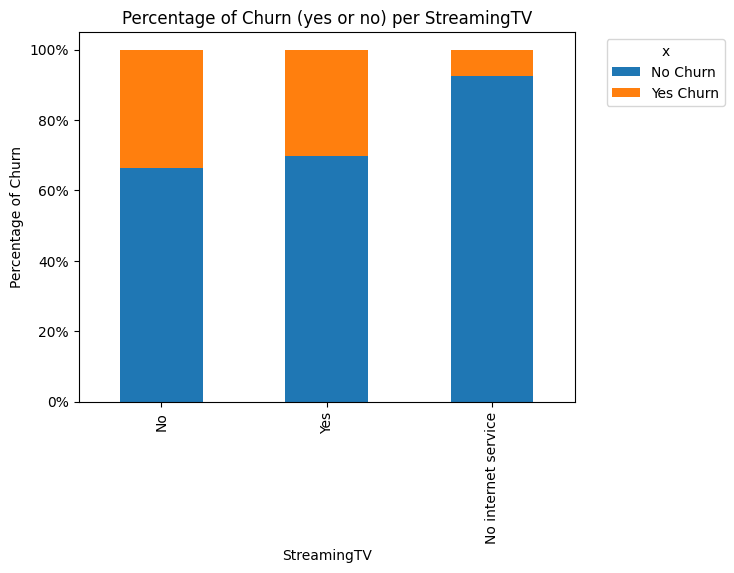

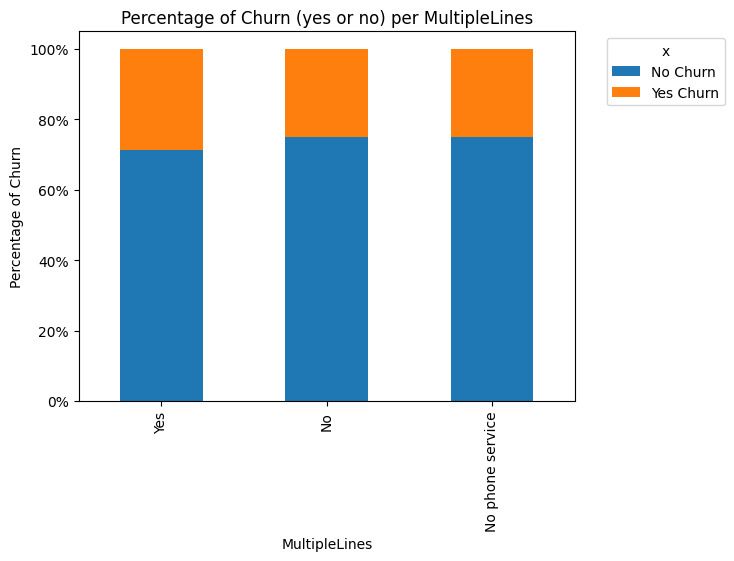

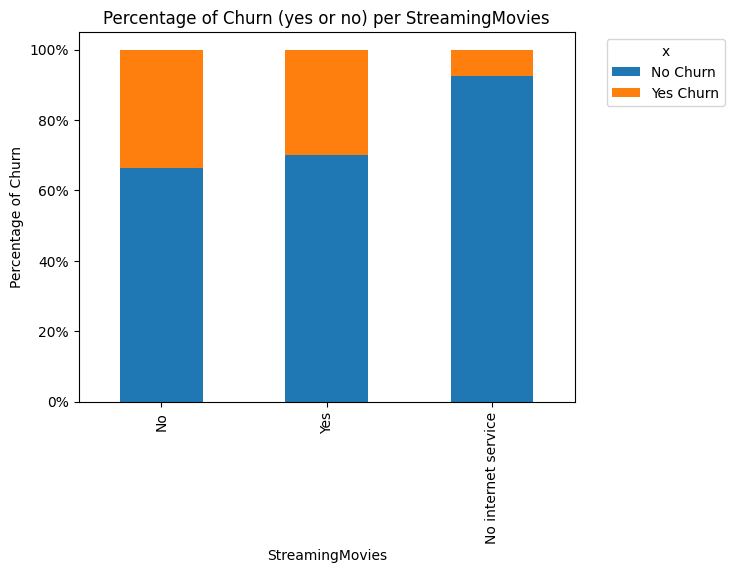

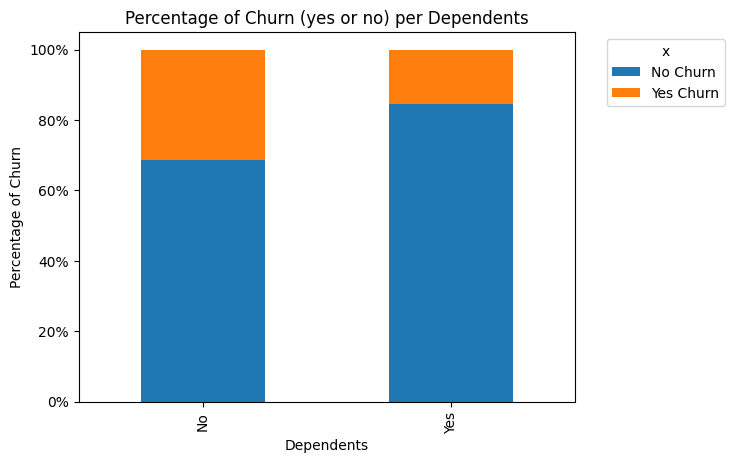

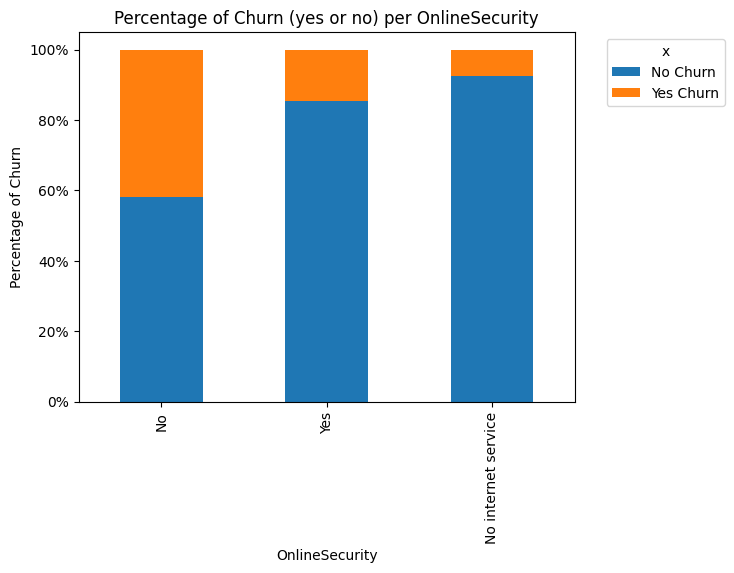

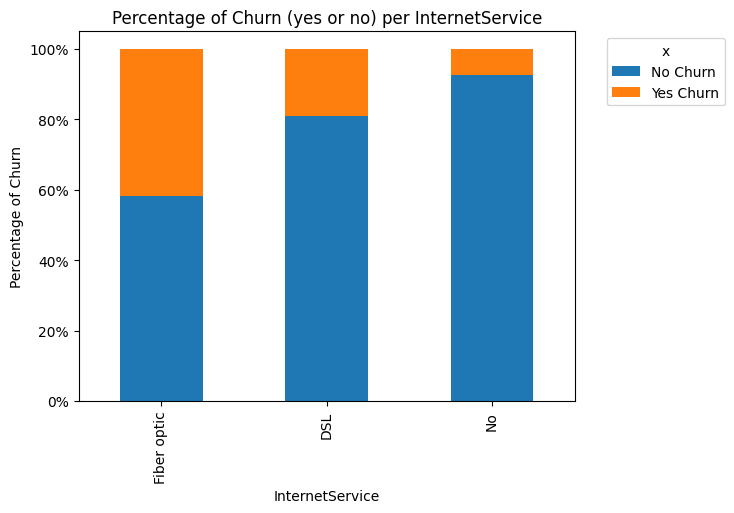

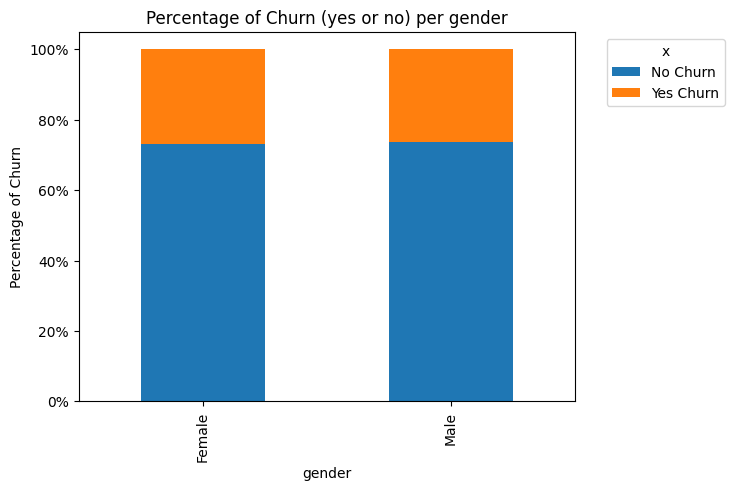

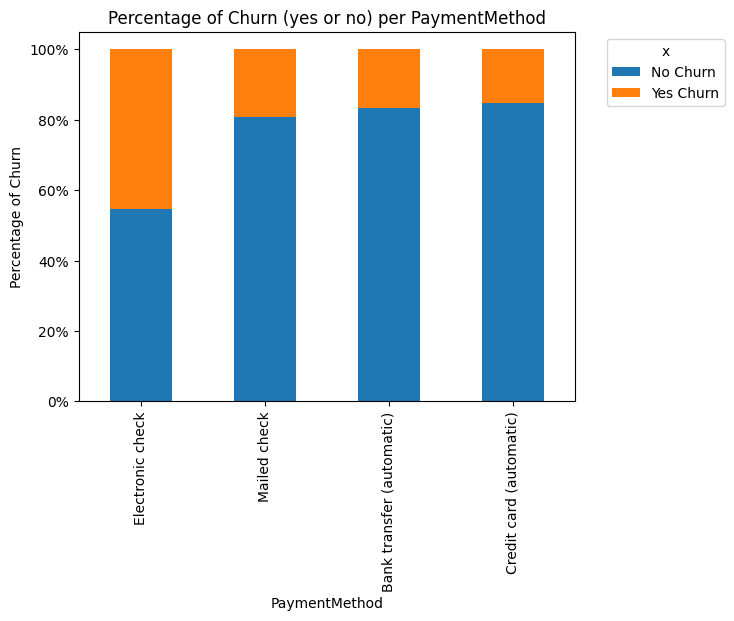

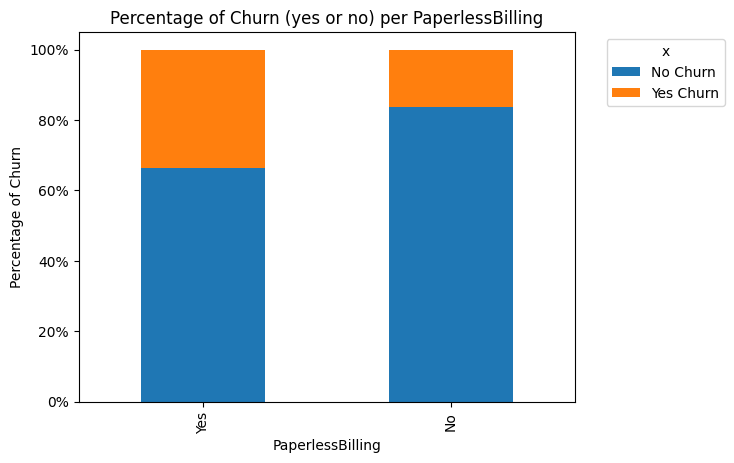

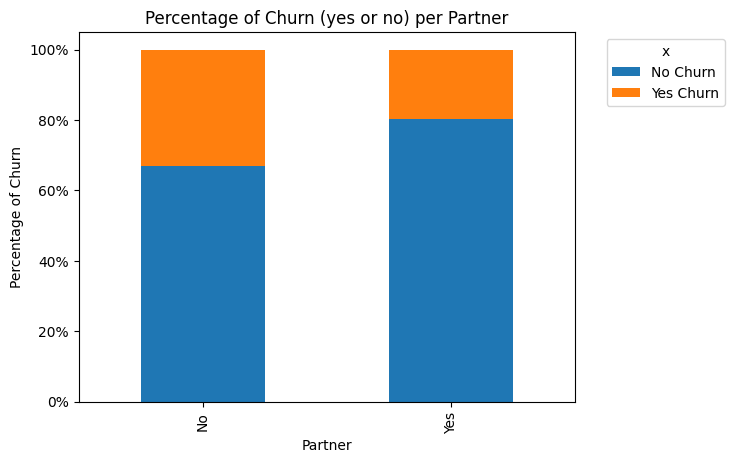

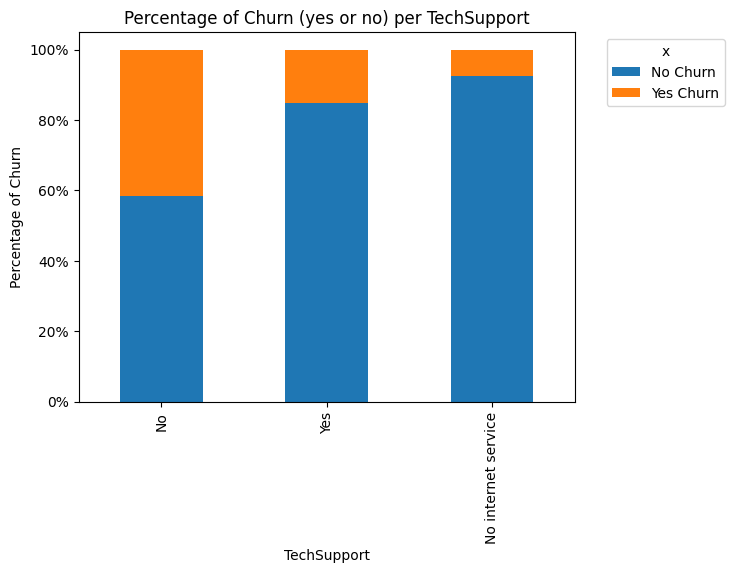

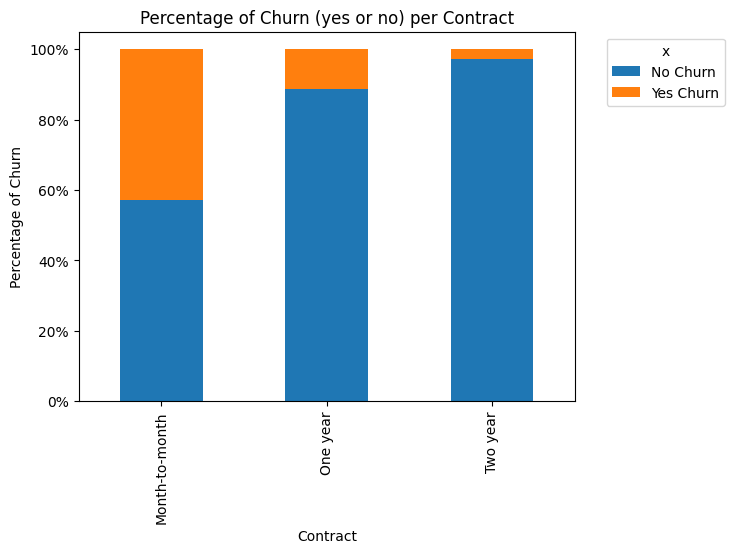

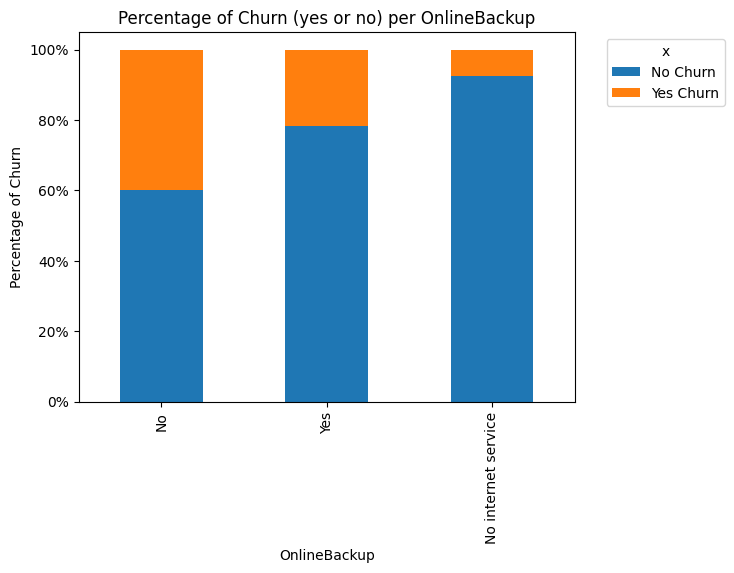

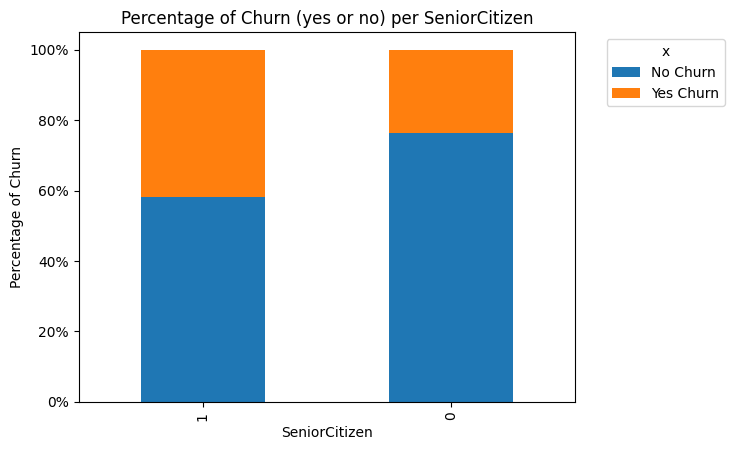

In [18]:
#Plot features with percentage of delays
data_label = 'Churn'
labels_description = ['No Churn','Yes Churn']
title_description = "Churn (yes or no)"
categorical_features.remove(data_label)
for feature in categorical_features:
    plot_stacked_barplot(data_label, feature, df, labels_description, title_description)
    

**Insights from stacked barplots**
- The following features seems to not have a big impact in churn: gender, multiple lines, and phone services;
- There are something factors/characteristcs present in the group of churned clients (not necessarily happining all in the same time):
    - No online securty, no streaming TV, not tech support, no streaming movies, no multiple lines, no online backup, no dependents,  no divice protection
    - Monthly contract, the person is a senior citizen, eletronic check payment, the person is not a partner
    - Have fiber optics

## 4) Classification model <a class="anchor" id="model"></a>

In [19]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),118.75,8672.45,No
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,118.65,8477.60,No
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,118.60,7990.05,No
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,118.60,7365.70,No
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),118.35,7804.15,Yes


In [20]:
# Dummy code the categorical column
features_to_dummy = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup','DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

# Dummy code the 'Category' column
df_dummies = pd.get_dummies(df, columns=features_to_dummy, drop_first=True, dtype=int)

df_dummies.head()

,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,7569-NMZYQ,0,72,118.75,8672.45,0,1,1,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,0,0,0
1,8984-HPEMB,0,71,118.65,8477.60,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0
2,5989-AXPUC,0,68,118.60,7990.05,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0
3,5734-EJKXG,0,61,118.60,7365.70,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,0
4,8199-ZLLSA,0,67,118.35,7804.15,1,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,0,1


In [21]:
df.drop(columns= ['customerID']).head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),118.75,8672.45,No
1,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,118.65,8477.60,No
2,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,118.60,7990.05,No
3,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,118.60,7365.70,No
4,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),118.35,7804.15,Yes


In [22]:
df_dummies.head()

,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,7569-NMZYQ,0,72,118.75,8672.45,0,1,1,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,0,0,0
1,8984-HPEMB,0,71,118.65,8477.60,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0
2,5989-AXPUC,0,68,118.60,7990.05,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0
3,5734-EJKXG,0,61,118.60,7365.70,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,0
4,8199-ZLLSA,0,67,118.35,7804.15,1,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,0,1


In [23]:
# Define sets
X = df_dummies.drop(columns= ['customerID', 'Churn_Yes'])
y = df_dummies['Churn_Yes']

**Classification metrics**
- Accuracy: It measures how often the classifier correctly predicts. It represents the proportion of correctly classified instances out of the total instances in the dataset. ;
- Precision: Precision explains how many of the correctly predicted cases actually turned out to be positive. It focuses on the correctness of positive predictions. "Of all the instances the model said are positive, how many are actually positive?"
    - Useful to minimize false positive (spam)
- Recall: Recall explains how many of the actual positive cases we were able to predict correctly with our model. "Of all the actual positive instances, how many did the model correctly identify?"
    - Useful to minimize false negative (disease)
- F1:  It gives a combined idea about Precision and Recall metrics, providing a single score. It is the harmonic mean of precision and recall.

[Reference 1](https://www.analyticsvidhya.com/blog/2021/07/metrics-to-evaluate-your-classification-model-to-take-the-right-decisions/)

[Reference 2](https://chat.openai.com/)

In [24]:
# Define classifiers
classifiers = {
    # 'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(silent=True),
    'XGBoost': XGBClassifier(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier()
}

# Define scoring metrics
scoring = ['accuracy', 'f1', 'recall', 'precision']

# Perform k-fold cross-validation and calculate multiple classification metrics
k_folds = 5
results = {}
for clf_name, clf in classifiers.items():
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Initialize a dictionary to store the scores for each metric
    scores = {}

    # Calculate each metric separately
    for metric in scoring:
        metric_scores = cross_val_score(clf, X, y, cv=kfold, scoring=metric)
        scores[f'test_{metric}'] = metric_scores

    results[clf_name] = scores

# Print the results
for clf_name, scores in results.items():
    mean_accuracy = scores['test_accuracy'].mean()
    mean_precision = scores['test_precision'].mean()
    mean_recall = scores['test_recall'].mean()
    mean_f1 = scores['test_f1'].mean()

    print(f"{clf_name}:")
    print(f"  Mean Accuracy = {mean_accuracy:.4f}")
    print(f"  Mean Precision = {mean_precision:.4f}")
    print(f"  Mean Recall = {mean_recall:.4f}")
    print(f"  Mean F1-score = {mean_f1:.4f}")
    print()

/home/jessica/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jessica/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jessica/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jessica/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: Undefi

CatBoost:
  Mean Accuracy = 0.7998
  Mean Precision = 0.6581
  Mean Recall = 0.5163
  Mean F1-score = 0.5783

XGBoost:
  Mean Accuracy = 0.7880
  Mean Precision = 0.6236
  Mean Recall = 0.5148
  Mean F1-score = 0.5637

SVM:
  Mean Accuracy = 0.7342
  Mean Precision = 0.0000
  Mean Recall = 0.0000
  Mean F1-score = 0.0000

Random Forest:
  Mean Accuracy = 0.7877
  Mean Precision = 0.6384
  Mean Recall = 0.4897
  Mean F1-score = 0.5591

Logistic Regression:
  Mean Accuracy = 0.8036
  Mean Precision = 0.6612
  Mean Recall = 0.5416
  Mean F1-score = 0.5950

Naive Bayes:
  Mean Accuracy = 0.6635
  Mean Precision = 0.4341
  Mean Recall = 0.8748
  Mean F1-score = 0.5802

Decision Tree:
  Mean Accuracy = 0.7274
  Mean Precision = 0.4859
  Mean Recall = 0.5018
  Mean F1-score = 0.4992



The models seems to be overfitting. Because the dataset is imbalanced (there is only 20% of delay), I decided to apply SMOTE to balance the dataset and try to solve the overfitting issue.

In [25]:
from imblearn.over_sampling import SMOTE
# transform the dataset
oversample = SMOTE()
print("Before applying SMOTE")
print("X.shape = ", X.shape)
print("y.shape = ", y.shape)
print("y.value_counts() = ",y.value_counts())
X, y = oversample.fit_resample(X, y)
print("After applying SMOTE")
print("X.shape = ", X.shape)
print("y.shape = ", y.shape)
print("y.value_counts() = ",y.value_counts())

Before applying SMOTE
X.shape =  (7032, 30)
y.shape =  (7032,)
y.value_counts() =  Churn_Yes
0    5163
1    1869
Name: count, dtype: int64
After applying SMOTE
X.shape =  (10326, 30)
y.shape =  (10326,)
y.value_counts() =  Churn_Yes
0    5163
1    5163
Name: count, dtype: int64


In [26]:
X.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,72,118.75,8672.45,0,1,1,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,0,0
1,0,71,118.65,8477.60,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0
2,0,68,118.60,7990.05,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1
3,0,61,118.60,7365.70,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0
4,0,67,118.35,7804.15,1,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,0


In [27]:
# Define classifiers
classifiers = {
    # 'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(silent=True),
    'XGBoost': XGBClassifier(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier()
}

# Define scoring metrics
scoring = ['accuracy', 'f1', 'recall', 'precision']

# Perform k-fold cross-validation and calculate multiple classification metrics
k_folds = 5
results = {}
for clf_name, clf in classifiers.items():
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Initialize a dictionary to store the scores for each metric
    scores = {}

    # Calculate each metric separately
    for metric in scoring:
        metric_scores = cross_val_score(clf, X, y, cv=kfold, scoring=metric)
        scores[f'test_{metric}'] = metric_scores

    results[clf_name] = scores

# Print the results
for clf_name, scores in results.items():
    mean_accuracy = scores['test_accuracy'].mean()
    mean_precision = scores['test_precision'].mean()
    mean_recall = scores['test_recall'].mean()
    mean_f1 = scores['test_f1'].mean()

    print(f"{clf_name}:")
    print(f"  Mean Accuracy = {mean_accuracy:.4f}")
    print(f"  Mean Precision = {mean_precision:.4f}")
    print(f"  Mean Recall = {mean_recall:.4f}")
    print(f"  Mean F1-score = {mean_f1:.4f}")
    print()

/home/jessica/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jessica/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

CatBoost:
  Mean Accuracy = 0.8468
  Mean Precision = 0.8379
  Mean Recall = 0.8599
  Mean F1-score = 0.8488

XGBoost:
  Mean Accuracy = 0.8417
  Mean Precision = 0.8372
  Mean Recall = 0.8485
  Mean F1-score = 0.8428

SVM:
  Mean Accuracy = 0.6599
  Mean Precision = 0.6784
  Mean Recall = 0.6075
  Mean F1-score = 0.6409

Random Forest:
  Mean Accuracy = 0.8430
  Mean Precision = 0.8378
  Mean Recall = 0.8524
  Mean F1-score = 0.8432

Logistic Regression:
  Mean Accuracy = 0.8228
  Mean Precision = 0.8062
  Mean Recall = 0.8501
  Mean F1-score = 0.8275

Naive Bayes:
  Mean Accuracy = 0.7837
  Mean Precision = 0.7375
  Mean Recall = 0.8811
  Mean F1-score = 0.8029

Decision Tree:
  Mean Accuracy = 0.7827
  Mean Precision = 0.7796
  Mean Recall = 0.7907
  Mean F1-score = 0.7856



**Model analysis**
- The best model was XGboost with SMOTE to deal with the imbalanced classes
- Metrics
- Mean Accuracy = 0.8449
    - Mean Precision = 0.8411
    - Mean Recall = 0.8505
    - Mean F1-score = 0.8457

Now, it is interesting to double check if the best model is not really overfitting. Let's check that bellow:

In [28]:
#X.reset_index(inplace=True)

In [29]:
# Define the classifier
clf = XGBClassifier()

# Perform k-fold cross-validation and calculate metrics
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

f1_scores_train = []
f1_scores_val = []
accuracy_scores_train = []
accuracy_scores_val = []
precision_scores_train = []
precision_scores_val = []
recall_scores_train = []
recall_scores_val = []

print("X.shape = " ,X.shape)
print("y.shape = " ,y.shape)
print("type(X) = ", type(X))
print("type(y) = ", type(y))


for train_index, val_index in kf.split(X):
    #print("train_index = ", train_index)
    #print("val_index = ", val_index)
    #X_train, X_val = X[train_index], X[val_index]
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Train the model
    clf.fit(X_train, y_train)

    # Make predictions on training and validation sets
    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)

    # Calculate metrics for training set
    f1_train = f1_score(y_train, y_train_pred, average='macro')
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred, average='macro')
    recall_train = recall_score(y_train, y_train_pred, average='macro')

    # Calculate metrics for validation set
    f1_val = f1_score(y_val, y_val_pred, average='macro')
    accuracy_val = accuracy_score(y_val, y_val_pred)
    precision_val = precision_score(y_val, y_val_pred, average='macro')
    recall_val = recall_score(y_val, y_val_pred, average='macro')

    # Append scores to lists
    f1_scores_train.append(f1_train)
    f1_scores_val.append(f1_val)
    accuracy_scores_train.append(accuracy_train)
    accuracy_scores_val.append(accuracy_val)
    precision_scores_train.append(precision_train)
    precision_scores_val.append(precision_val)
    recall_scores_train.append(recall_train)
    recall_scores_val.append(recall_val)

# Calculate mean scores for training and validation sets
mean_f1_train = np.mean(f1_scores_train)
mean_f1_val = np.mean(f1_scores_val)
mean_accuracy_train = np.mean(accuracy_scores_train)
mean_accuracy_val = np.mean(accuracy_scores_val)
mean_precision_train = np.mean(precision_scores_train)
mean_precision_val = np.mean(precision_scores_val)
mean_recall_train = np.mean(recall_scores_train)
mean_recall_val = np.mean(recall_scores_val)

# Print the results
print("Mean F1-score (Training):", mean_f1_train)
print("Mean F1-score (Validation):", mean_f1_val)
print("Mean Accuracy (Training):", mean_accuracy_train)
print("Mean Accuracy (Validation):", mean_accuracy_val)
print("Mean Precision (Training):", mean_precision_train)
print("Mean Precision (Validation):", mean_precision_val)
print("Mean Recall (Training):", mean_recall_train)
print("Mean Recall (Validation):", mean_recall_val)


X.shape =  (10326, 30)
y.shape =  (10326,)
type(X) =  <class 'pandas.core.frame.DataFrame'>
type(y) =  <class 'pandas.core.series.Series'>


Mean F1-score (Training): 0.9549391829980938
Mean F1-score (Validation): 0.8416428368357671
Mean Accuracy (Training): 0.9549437407251846
Mean Accuracy (Validation): 0.8416616310658676
Mean Precision (Training): 0.955120341536
Mean Precision (Validation): 0.8417676407331852
Mean Recall (Training): 0.954942264985184
Mean Recall (Validation): 0.8416610108507024


- The training data has better performance than the validation set but it is not an extreme difference

## 5) Feature importance <a class="anchor" id="feature-importance"></a>

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


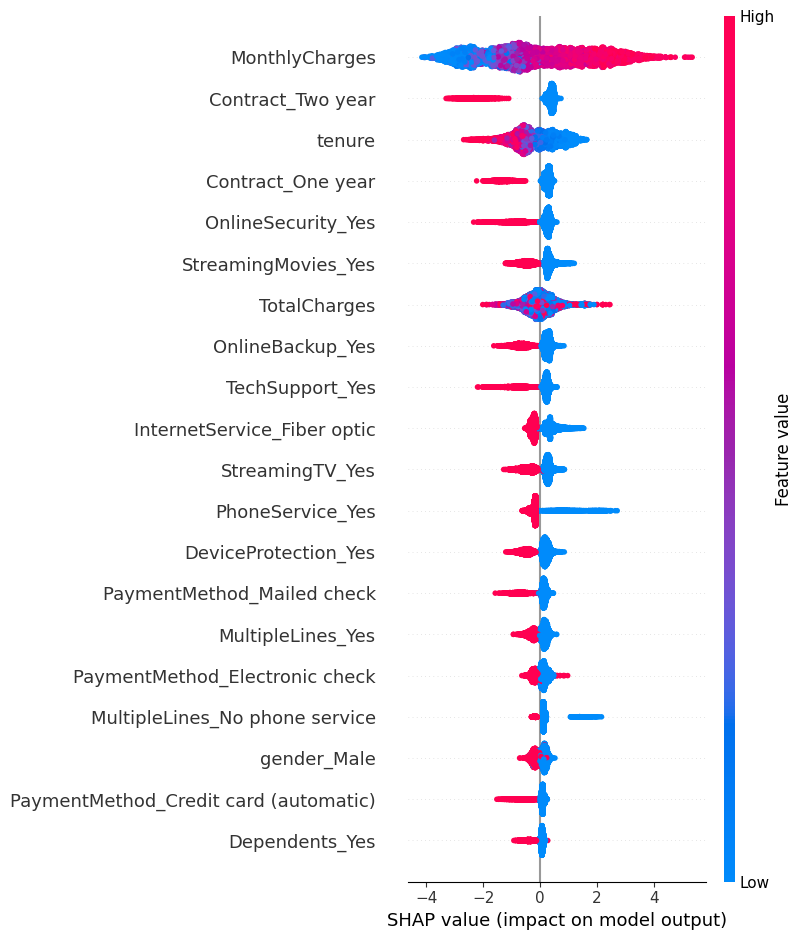

In [30]:
import shap

# Create an explainer object for the XGBoost model
explainer = shap.Explainer(clf)

# Calculate SHAP values for the entire training dataset
shap_values = explainer.shap_values(X_train)


# Plot the SHAP values for a single instance (e.g., the first instance in the dataset)
shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[0, :])

# Alternatively, you can plot the summary plot for all instances
shap.summary_plot(shap_values, X_train)


In [31]:
X.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,72,118.75,8672.45,0,1,1,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,0,0
1,0,71,118.65,8477.60,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0
2,0,68,118.60,7990.05,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1
3,0,61,118.60,7365.70,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0
4,0,67,118.35,7804.15,1,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,0


**Shap plot analysis**
- hi